In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix


In [ ]:
# Read text data from a text file with a different encoding
with open('/content/drive/Shareddrives/DD/FINAL AI/Financial Phrases/Sentences.txt', 'r', encoding='ISO-8859-1') as file:
    df = file.readlines()


In [ ]:

# print the first five rows of the dataset
print(df)


['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral\n', "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .@positive\n", 'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .@positive\n', 'Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .@positive\n', 'Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .@positive\n', 'Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .@positive\n', "Clothing retail chain Sepp+ñl+ñ 's sales increased by 8 % to EUR 155.2 mn , 

In [ ]:
import csv

# Define the paths
input_path = '/content/drive/Shareddrives/DD/FINAL AI/Financial Phrases/Sentences.txt'
output_path = '/content/drive/Shareddrives/DD/FINAL AI/Financial Phrases/Sentences.csv'

# Read the content from the text file
with open(input_path, 'r',encoding='ISO-8859-1') as txt_file:
    lines = txt_file.readlines()


# Write to the CSV file
with open(output_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows([line.strip()] for line in lines)

print("Text file converted to CSV successfully.")


Text file converted to CSV successfully.


In [ ]:
# load the dataset
data_path="/content/drive/Shareddrives/DD/FINAL AI/Financial Phrases/Sentences.csv"
df = pd.read_csv(data_path,engine="python",encoding="ISO-8859-1")

In [ ]:
df.head()

,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral"
0,"For the last quarter of 2010 , Componenta 's n..."
1,"In the third quarter of 2010 , net sales incre..."
2,Operating profit rose to EUR 13.1 mn from EUR ...
3,"Operating profit totalled EUR 21.1 mn , up fro..."
4,Finnish Talentum reports its operating profit ...


In [ ]:
df.isnull().any()

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral    False
dtype: bool

In [ ]:
# Initialize lists to store data
sentiments = []
texts = []

# Process each line and extract information
for line in lines:
    parts = line.strip().split('@')
    if len(parts) == 2:
        text = parts[0].strip()
        sentiment = parts[1].strip()
        sentiments.append(sentiment)
        texts.append(text)

# Create a DataFrame
df = { 'Label': sentiments, 'Text': texts}
data = pd.DataFrame(df)

# Save the DataFrame to a CSV file
data.to_csv('/content/drive/Shareddrives/DD/FINAL AI/Financial Phrases/Sentences.csv', index=False)

# Display the DataFrame
data

,Label,Text
0,neutral,"According to Gran , the company has no plans t..."
1,positive,"For the last quarter of 2010 , Componenta 's n..."
2,positive,"In the third quarter of 2010 , net sales incre..."
3,positive,Operating profit rose to EUR 13.1 mn from EUR ...
4,positive,"Operating profit totalled EUR 21.1 mn , up fro..."
...,...,...
2259,negative,Operating result for the 12-month period decre...
2260,negative,HELSINKI Thomson Financial - Shares in Cargote...
2261,negative,LONDON MarketWatch -- Share prices ended lower...
2262,negative,Operating profit fell to EUR 35.4 mn from EUR ...


<Axes: xlabel='count', ylabel='Label'>

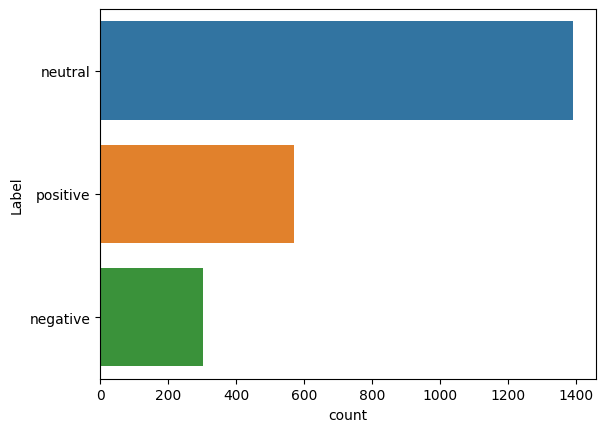

In [ ]:
sns.countplot(y="Label",data=data)


In [ ]:
data.isnull().sum()

Label    0
Text     0
dtype: int64

In [ ]:
# remove unwanted text and characters
data['Text'] = data['Text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))


In [ ]:
data.sample(5)

,Label,Text
615,neutral,The Group owns and operates a fleet of more th...
1559,neutral,Union and company officials did not return cal...
585,neutral,Prothious Engineering wwwprothiouscom employ...
2164,negative,Orion s net profit for the third quarter of 20...
1424,neutral,The divested stake represented about 27 m shar...


In [ ]:
# normalize text data
data['Text'] = data['Text'].apply(lambda x: x.lower())


In [ ]:
def get_sequences(texts, max_seq_length=52):  # Change max_seq_length to match the model's expected input length
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)

    sequences = tokenizer.texts_to_sequences(texts)
    print("Vocab length:", len(tokenizer.word_index) + 1)

    # Pad sequences to the specified max_seq_length
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

    return sequences

In [ ]:
sequences = get_sequences(texts)

Vocab length: 6110


In [ ]:
def preprocess_inputs(df):
    df = df.copy()

    sequences = get_sequences(df['Text'])

    label_mapping = {
        'negative': 0,
        'neutral': 1,
        'positive': 2
    }

    y = df['Label'].replace(label_mapping)

    train_sequences, test_sequences, y_train, y_test = train_test_split(
        sequences, y, train_size=0.7, shuffle=True, random_state=1)

    return train_sequences, test_sequences, y_train, y_test, label_mapping


In [ ]:
train_sequences, test_sequences, y_train, y_test, label_mapping = preprocess_inputs(data)


Vocab length: 6741


In [ ]:
train_sequences

array([[   1,  176,   72, ...,    0,    0,    0],
       [   1,  157,   15, ...,    0,    0,    0],
       [2462,   28,  788, ...,    0,    0,    0],
       ...,
       [   1,   86, 1031, ...,    0,    0,    0],
       [ 827,   59,  944, ...,    0,    0,    0],
       [   1,  730,   68, ...,    0,    0,    0]], dtype=int32)

In [ ]:
y_train

2252    0
259     2
1118    1
1910    0
2089    1
       ..
960     1
905     1
1096    1
235     2
1061    1
Name: Label, Length: 1584, dtype: int64

## Build a Model

In [ ]:
# inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
# x = tf.keras.layers.Embedding(
#     input_dim=10123,
#     output_dim=128,
#     input_length=train_sequences.shape[1]
# )(inputs)
# x = tf.keras.layers.GRU(256, return_sequences=True, activation='tanh')(x)
# x = tf.keras.layers.Flatten()(x)
# outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
# model = tf.keras.Model(inputs=inputs, outputs=outputs)

inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(
    input_dim=10123,
    output_dim=128,
    input_length=train_sequences.shape[1]
)(inputs)
x = tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 52)]              0         
                                                                 
 embedding (Embedding)       (None, 52, 128)           1295744   
                                                                 
 lstm (LSTM)                 (None, 52, 256)           394240    
                                                                 
 flatten (Flatten)           (None, 13312)             0         
                                                                 
 dense (Dense)               (None, 3)                 39939     
                                                                 
Total params: 1,729,923
Trainable params: 1,729,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



## Training Model

In [ ]:

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True )
# Train the model with the EarlyStopping callback
history = model.fit( train_sequences, y_train, validation_split=0.2, batch_size=32, epochs=10, callbacks=[early_stopping])



Epoch 1/10
40/40 [==============================] - 17s 246ms/step - loss: 0.8031 - accuracy: 0.6630 - val_loss: 0.6320 - val_accuracy: 0.7350
Epoch 2/10
40/40 [==============================] - 5s 121ms/step - loss: 0.4091 - accuracy: 0.8145 - val_loss: 0.6300 - val_accuracy: 0.7413
Epoch 3/10
40/40 [==============================] - 5s 121ms/step - loss: 0.1690 - accuracy: 0.9384 - val_loss: 0.7006 - val_accuracy: 0.8233
Epoch 4/10
40/40 [==============================] - 3s 72ms/step - loss: 0.0498 - accuracy: 0.9890 - val_loss: 0.4909 - val_accuracy: 0.8423
Epoch 5/10
40/40 [==============================] - 2s 48ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 1.1872 - val_accuracy: 0.8391
Epoch 6/10
40/40 [==============================] - 3s 66ms/step - loss: 0.0038 - accuracy: 0.9984 - val_loss: 1.0317 - val_accuracy: 0.8423


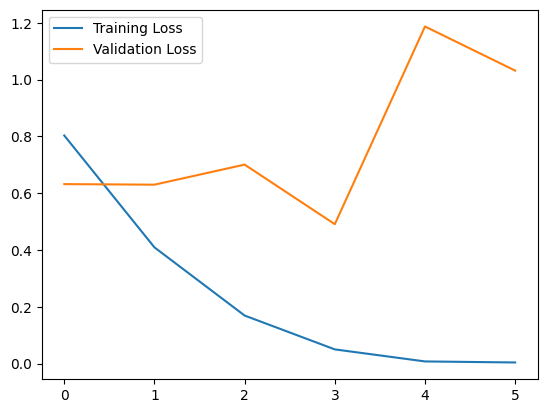

In [ ]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

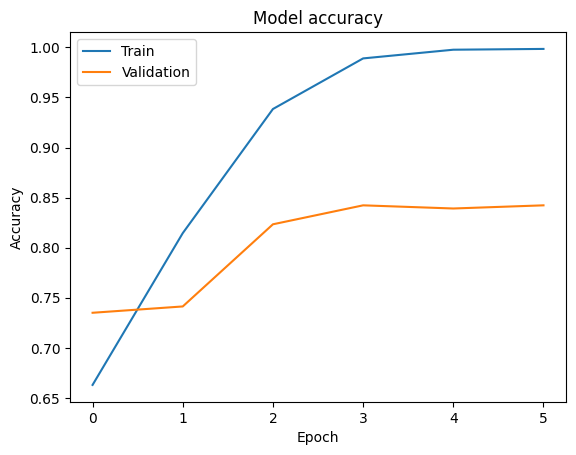

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Evaluate the Model

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_sequences, y_test)

print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

22/22 [==============================] - 0s 5ms/step - loss: 0.5395 - accuracy: 0.8353
Test Loss: 0.5395, Test Accuracy: 0.8353


In [ ]:
y_pred = model.predict(test_sequences)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Convert numerical labels back to text labels
label_mapping_inv = {v: k for k, v in label_mapping.items()}
y_test_labels = y_test.replace(label_mapping_inv)
y_pred_labels = [label_mapping_inv[pred] for pred in y_pred_classes]

# Compare actual labels with predicted labels
for true_label, pred_label in zip(y_test_labels, y_pred_labels):
    print(f"True Label: {true_label}\tPredicted Label: {pred_label}")


22/22 [==============================] - 0s 4ms/step
True Label: negative	Predicted Label: negative
True Label: neutral	Predicted Label: positive
True Label: neutral	Predicted Label: neutral
True Label: neutral	Predicted Label: neutral
True Label: negative	Predicted Label: neutral
True Label: neutral	Predicted Label: neutral
True Label: neutral	Predicted Label: neutral
True Label: neutral	Predicted Label: positive
True Label: neutral	Predicted Label: neutral
True Label: negative	Predicted Label: negative
True Label: neutral	Predicted Label: neutral
True Label: positive	Predicted Label: positive
True Label: neutral	Predicted Label: neutral
True Label: neutral	Predicted Label: neutral
True Label: neutral	Predicted Label: neutral
True Label: neutral	Predicted Label: neutral
True Label: negative	Predicted Label: negative
True Label: neutral	Predicted Label: neutral
True Label: positive	Predicted Label: positive
True Label: neutral	Predicted Label: neutral
True Label: negative	Predicted Lab

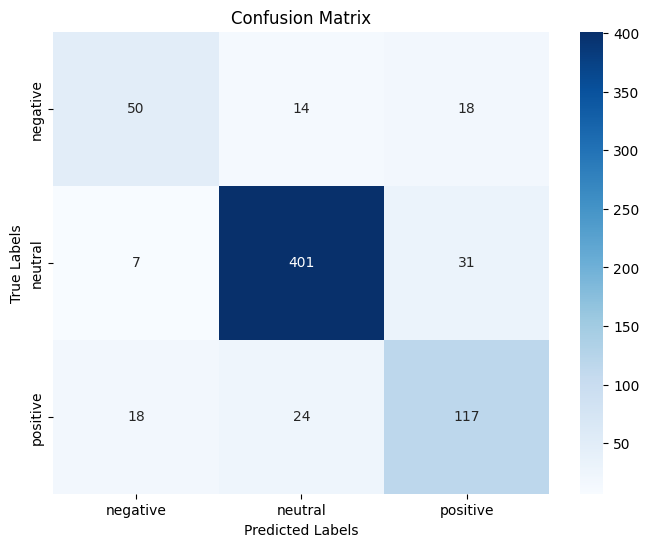

In [ ]:
# Create a list of label strings in the correct order
label_strings = ['negative', 'neutral', 'positive']

# Convert true and predicted labels to their corresponding integer values
y_test_int = y_test.replace(label_mapping)
y_pred_int = [label_mapping[pred] for pred in y_pred_labels]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred_int, labels=list(label_mapping.values()))

# Create a DataFrame for the confusion matrix
conf_df = pd.DataFrame(conf_matrix, index=label_mapping.keys(), columns=label_mapping.keys())

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()





In [ ]:

# Row index to check
row_to_check = 2248

# Check if the row index is valid
if 0 <= row_to_check < len(data):
    text_data = [data.iloc[row_to_check]["Text"]]  # Get the text from the selected row

    # Preprocess the text using your get_sequences function
    sequences = get_sequences(text_data)

    # Make predictions using the model
    user_pred = model.predict(sequences)

    # print the values
    print(text_data)

    user_pred_class = np.argmax(user_pred, axis=1)[0]
    user_pred_label = label_mapping_inv[user_pred_class]

    print("Predicted Sentiment:", user_pred_label)
else:
    print("Invalid row number. Please provide a valid row number.")


Vocab length: 15
1/1 [==============================] - 0s 61ms/step
[' capital expenditure on energy efficiency has unfortunately fallen along with the decline in the economy ']
Predicted Sentiment: neutral


In [ ]:
# (positive)
# operating profit totalled eur 211 mn  up from eur 186 mn in 2007  representing 97  of net sales
# clothing retail chain seppl s sales increased by 8  to eur 1552 mn  and operating profit rose to eur 311 mn from eur 171 mn in 2004
# operating profit was eur 245 mn  up from eur 230 mn
# (neutral)
# according to gran  the company has no plans to move all production to russia  although that is where the company is growing
# capital expenditure on energy efficiency has unfortunately fallen along with the decline in the economy
# (negative)
# ['finnish silicon wafer technology company okmetic oyj  omx helsinki  okm1v  reported on thursday  7 august  an operating profit of eur5 3 m for the period januaryjune 2008  up from eur3 3 m in the corresponding period in 2007 ']
# ['finnish broadband data communication systems provider teleste oyj hel  tlt1v said yesterday it returned to a net profit of eur 27 million usd 38 m for the first nine months of 2010 versus a net loss of eur 579000 for the same period of 2009 ']



In [ ]:
while True:
    user_input = input("Enter a text (or 'exit' to quit): ")

    if user_input.lower() == 'exit':
        break

    # Preprocess the user's input text
    user_sequence = get_sequences([user_input])

    # Make predictions using the model
    user_pred = model.predict(user_sequence)

    # Assuming label_mapping_inv is a dictionary that maps class indices to labels
    user_pred_class = np.argmax(user_pred, axis=1)[0]
    user_pred_label = label_mapping_inv[user_pred_class]

    print("Predicted Sentiment:", user_pred_label)


Enter a text (or 'exit' to quit): capital expenditure on energy efficiency has unfortunately fallen along with the decline in the economy
Vocab length: 15
1/1 [==============================] - 0s 18ms/step
Predicted Sentiment: neutral
Enter a text (or 'exit' to quit): operating profit totalled eur 211 mn  up from eur 186 mn in 2007  representing 97  of net sales
Vocab length: 17
1/1 [==============================] - 0s 31ms/step
Predicted Sentiment: positive
Enter a text (or 'exit' to quit): finnish silicon wafer technology company okmetic oyj  omx helsinki  okm1v  reported on thursday  7 august  an operating profit of eur5 3 m for the period januaryjune 2008  up from eur3 3 m in the corresponding period in 2007
Vocab length: 34
1/1 [==============================] - 0s 19ms/step
Predicted Sentiment: negative
Enter a text (or 'exit' to quit): finnish broadband data communication systems provider teleste oyj hel  tlt1v said yesterday it returned to a net profit of eur 27 million usd 3